# Imagenet
ImageNet, is a dataset of over 15 millions labeled high-resolution images with around 22,000 categories. ILSVRC uses a subset of ImageNet of around 1000 images in each of 1000 categories. In all, there are roughly 1.3 million training images, 50,000 validation images and 100,000 testing images.

* Main idea was as the depth of the network increase error decreases

* Second position in  ILSVRC 2014

# Why VGG16

* By using 2 layers of 3×3 filters, it actually have already covered 5×5 area. By using 3 layers of 3×3 filters, it actually have already covered 7×7 effective area. Thus, large-size filters such as 11×11 in AlexNet and 7×7 in ZFNetindeed are not needed.

* Another reason is that the number of parameters are fewer.

For example:
1 layer of 11×11 filter, number of parameters = 11×11=121M<br>
5 layer of 3×3 filter, number of parameters = 3×3×5=45<br>
   Number of parameters is reduced by 63%<br>
<br>

1 layer of 7×7 filter, number of parameters = 7×7=49<br>
3 layers of 3×3 filters, number of parameters = 3×3×3=27<br>
Number of parameters is reduced by 45%<br>




# Shortcomings of VGG

* can have vanishing gradient problem due to deeper network

* More training time and inference time.

* It has so many weight parameters 


# Architecture
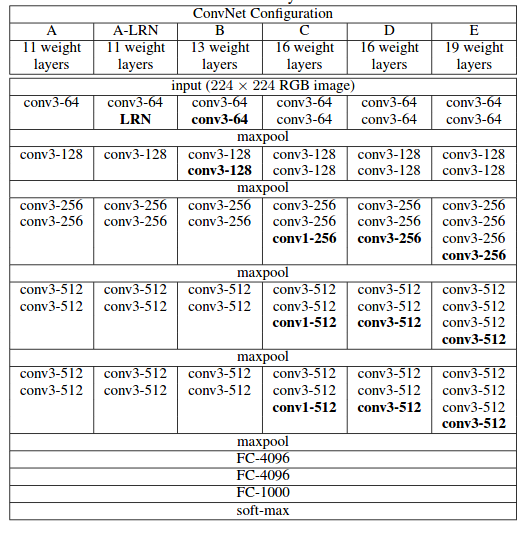



---



---



In this notebook we will implemnet VGG network from scratch. We will make a common implementation in which we can call any of VGG11,VGG13,VGG16,VGG19 accordingly. <br>


In [0]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import requests
import os
from torch.hub import load_state_dict_from_url

In [0]:
channel_dict = {'vgg11' : [64,'MP',128,'MP',256,256,'MP',512,512,'MP',512,512,'MP'],
'vgg13' : [64, 64, 'MP', 128, 128, 'MP', 256, 256, 'MP', 512, 512, 'MP', 512, 512, 'MP'],
'vgg16' :  [64, 64, 'MP', 128, 128, 'MP', 256, 256, 256, 'MP', 512, 512, 512, 'MP', 512, 512, 512, 'MP'],
'vgg19' : [64, 64, 'MP', 128, 128, 'MP', 256, 256, 256, 256, 'MP', 512, 512, 512, 512, 'MP', 512, 512, 512, 512, 'MP']}


weight_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
    'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth',
    'vgg13_bn': 'https://download.pytorch.org/models/vgg13_bn-abd245e5.pth',
    'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth',
    'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth',
}

In [0]:
# utiliy functions
def create_layers(channel_list,batch_norm=False):
  seq_list = []
  input_channels = 3
  for channel in channel_list:
    if channel == 'MP':
      seq_list.append(nn.MaxPool2d(kernel_size=2,stride=2))
    else:
      conv_layer = nn.Conv2d(in_channels = input_channels, kernel_size=3, out_channels=channel, stride=1)
      if batch_norm:
        bn = nn.BatchNorm2d(channel)
        seq_list.extend([conv_layer,bn,nn.ReLU(inplace=True)])
      else:
        seq_list.extend([conv_layer,nn.ReLU(inplace=True)])
          
      input_channels = channel

  return nn.Sequential(*seq_list)


# function which helps to load the weights
def load_weights(model,weight_url):
    state_dict = load_state_dict_from_url(weight_url)
    model.load_state_dict(state_dict)
    return model



In [0]:
class VGG(nn.Module):
  def __init__(self,model,batch_norm=False, weight_initialize=True):
    super(VGG, self).__init__()
    if batch_norm:
        self.features = create_layers(channel_dict[model],batch_norm=True)
    else:
        self.features = create_layers(channel_dict[model],batch_norm=False)
    self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
    

    num_classes = 1000
    self.classifier = nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, num_classes),
        )    
  
    if weight_initialize:
        self._initialize_weights()
    
  def forward(self,x):
      x = self.features(x)
      x = self.avgpool(x)
      x = torch.flatten(x,1)
      x = self.classifier(x)
      return x


  def _initialize_weights(self):
      for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


   

# Normal initialization of model

In [0]:

model = VGG(model='vgg16',batch_norm=True,weight_initialize=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (15): BatchNorm2d(256, 

# Loading pretrained weights


In [0]:
model = VGG(model='vgg16',batch_norm=True)
model = load_weights(model,weight_urls['vgg16_bn'])
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (15): BatchNorm2d(256, 